In [28]:
import os
from dotenv import load_dotenv
from typing import List, TypedDict

from langchain_core.documents import Document
from langchain.prompts import PromptTemplate
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, END

# --- API 키 로드 ---
load_dotenv()

# --- 1. Graph State 정의 ---
class GraphState(TypedDict):
    question: str
    documents: List[Document]
    generation: str

# --- 2. Vector Store 및 Retriever 준비 ---
loader = CSVLoader(file_path='db_drug_interactions.csv', encoding='utf-8')
docs = loader.load()[:1000]
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vector_store = FAISS.from_documents(docs, embeddings)
retriever = vector_store.as_retriever(search_kwargs={'k': 5})

# --- 3. 웹 검색 도구 및 LLM 준비 ---
web_search_tool = TavilySearchResults(k=3)
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# --- 4. LangGraph 노드 정의 (내부 print문 제거) ---

def retrieve(state):
    question = state["question"]
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def grade_documents(state):
    question = state["question"]
    documents = state["documents"]
    if not documents:
        return "websearch"
    prompt = PromptTemplate.from_template(
        "사용자의 질문에 대해 검색된 문서들이 관련성이 높으면 'yes', 아니면 'no'만 반환해줘.\n\n[문서]: {documents}\n[질문]: {question}"
    )
    grader_chain = prompt | llm
    docs_str = "\n\n".join([d.page_content for d in documents])
    response = grader_chain.invoke({"documents": docs_str, "question": question})
    if "yes" in response.content.lower():
        return "generate"
    else:
        return "websearch"

def generate(state):
    question = state["question"]
    documents = state["documents"]
    prompt = PromptTemplate.from_template(
        "주어진 정보만을 바탕으로 질문에 대해 답변해줘.\n\n[정보]: {context}\n[질문]: {question}"
    )
    rag_chain = prompt | llm
    docs_str = "\n\n".join([d.page_content for d in documents])
    generation = rag_chain.invoke({"context": docs_str, "question": question})
    return {"generation": generation.content}

def web_search(state):
    question = state["question"]
    web_results = web_search_tool.invoke({"query": question})
    web_docs = [Document(page_content=d["content"], metadata={"source": d["url"]}) for d in web_results]
    return {"documents": web_docs, "question": question}

# --- 5. Graph 구성 ---
workflow = StateGraph(GraphState)
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)
workflow.add_node("web_search", web_search)
workflow.set_entry_point("retrieve")
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
    {"generate": "generate", "websearch": "web_search"},
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)
app = workflow.compile()

# --- 6. 최종 결과 출력 함수 (이미지 형식에 맞게 수정) ---
def run_graph(question: str):
    print("---")
    print(f"[질문]\n{question}")

    # invoke를 사용하여 최종 결과만 한 번에 받습니다.
    final_state = app.invoke({"question": question})
    
    # 최종 답변 출력
    print("\n[답변]")
    print(final_state.get("generation", "답변을 생성하지 못했습니다."))
    
    # 출처 문서 출력
    print("\n[출처]")
    documents = final_state.get("documents", [])
    
    if not documents:
        print("출처를 찾을 수 없습니다.")
    else:
        # 중복된 출처 URL 제거 후 번호를 붙여 출력
        unique_sources = set()
        for doc in documents:
            if hasattr(doc, 'metadata') and doc.metadata.get('source'):
                unique_sources.add(doc.metadata['source'])
        
        if not unique_sources:
            print("출처 URL을 찾을 수 없습니다.")
        else:
            for i, source in enumerate(unique_sources, 1):
                print(f"{i}. {source}")

# --- 7. 직접 실행할 때만 작동하도록 수정 ---
if __name__ == "__main__":
    run_graph("코로나 백신과 타이레놀의 상호작용에 대한 최신 정보 알려줘")
    run_graph("Aspirin과 상호작용하는 약물은 무엇인가요?")

---
[질문]
코로나 백신과 타이레놀의 상호작용에 대한 최신 정보 알려줘

[답변]
현재까지의 정보에 따르면, 코로나19 백신과 타이레놀(아세트아미노펜) 사이에 특별한 상호작용이 보고된 바는 없습니다. 그러나, 백신 접종 후 발열이나 근육통과 같은 일시적인 부작용이 발생할 수 있으므로 이러한 증상이 나타날 경우에는 의료진의 지시에 따라 타이레놈을 복용하는 것이 권장될 수 있습니다. 하지만, 항열제나 진통제의 복용은 개인의 상황에 따라 다를 수 있으므로 의사나 약사와 상의하는 것이 좋습니다. 최신 정보를 확인하기 위해서는 의료 전문가의 조언을 따르는 것이 중요합니다.

[출처]
1. https://www.cdph.ca.gov/Programs/CID/DCDC/CDPH%20Document%20Library/COVID-19/Translations/Pfizer-COVID-19-Vaccine-Risks-and-Benefits--ko.pdf
2. https://snuh.org/m/board/B003/view.do?bbs_no=6585&searchKey=&searchWord=2023&pageIndex=1
3. https://www.sandiegocounty.gov/content/dam/sdc/hhsa/programs/phs/Epidemiology/covid19/vaccines/General_COVID-19_Vaccine_Myth_v_Fact_Korean.pdf
4. https://www.jcohns.org/archive/view_article?pid=jcohns-33-2-92
5. https://www.k-health.com/news/articleView.html?idxno=53360
---
[질문]
Aspirin과 상호작용하는 약물은 무엇인가요?

[답변]
[답변]: 아스피린과 상호작용하는 약물로는 아세타졸아마이드, 염화 암모늄, 알코올, 토르부타마이드, 클로르프로파마이드, 와파린, 메토트렉세이트, 페니토인, 이부프로펜, 나프록센, 코르티코스테로이드, 리튬제제, 디곡신,

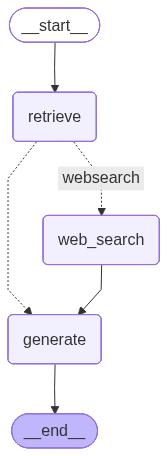

In [51]:
import os
from dotenv import load_dotenv
from typing import List, TypedDict

# --- Notebook에서 이미지를 표시하기 위한 라이브러리 ---
from IPython.display import Image, display

# --- LangChain 및 LangGraph 관련 라이브러리 ---
from langchain_core.documents import Document
from langchain.prompts import PromptTemplate
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, END

# --- 1. 환경 변수 로드 ---
load_dotenv()
# API 키가 .env 파일에 없다면 직접 설정하세요.
# os.environ["OPENAI_API_KEY"] = "YOUR_OPENAI_API_KEY"
# os.environ["TAVILY_API_KEY"] = "YOUR_TAVILY_API_KEY"

# --- 2. Graph State, 도구, LLM 준비 ---
class GraphState(TypedDict):
    question: str
    documents: List[Document]
    generation: str

# 가상의 CSV 파일 생성
with open('db_drug_interactions.csv', 'w', encoding='utf-8') as f:
    f.write("Drug,Interaction\n")
    f.write("Aspirin,Ibuprofen can decrease the antiplatelet effect of aspirin.\n")
    f.write("Warfarin,Vitamin K can reduce the anticoagulant effects of warfarin.\n")

loader = CSVLoader(file_path='db_drug_interactions.csv', encoding='utf-8')
docs = loader.load()
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vector_store = FAISS.from_documents(docs, embeddings)
retriever = vector_store.as_retriever(search_kwargs={'k': 5})
web_search_tool = TavilySearchResults(k=3)
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# --- 3. LangGraph 노드 정의 (이전 코드와 동일) ---
def retrieve(state):
    print("--- 노드: retrieve ---")
    question = state["question"]
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def grade_documents(state):
    print("--- 노드: grade_documents (조건부 엣지) ---")
    question = state["question"]
    documents = state["documents"]
    if not documents or all(d.page_content == "" for d in documents):
        print("-> 문서 없음, 웹 검색으로 라우팅")
        return "websearch"
    prompt = PromptTemplate.from_template("사용자의 질문에 대해 검색된 문서들이 관련성이 높으면 'yes', 아니면 'no'만 반환해줘.\n\n[문서]: {documents}\n[질문]: {question}")
    grader_chain = prompt | llm
    docs_str = "\n\n".join([d.page_content for d in documents])
    response = grader_chain.invoke({"documents": docs_str, "question": question})
    if "yes" in response.content.lower():
        print("-> 문서 관련성 높음, 답변 생성으로 라우팅")
        return "generate"
    else:
        print("-> 문서 관련성 낮음, 웹 검색으로 라우팅")
        return "websearch"

def generate(state):
    print("--- 노드: generate ---")
    question = state["question"]
    documents = state["documents"]
    prompt = PromptTemplate.from_template("주어진 정보만을 바탕으로 질문에 대해 답변해줘. 출처를 명시해줘.\n\n[정보]: {context}\n[질문]: {question}")
    rag_chain = prompt | llm
    docs_str = "\n\n".join([d.page_content for d in documents])
    generation = rag_chain.invoke({"context": docs_str, "question": question})
    return {"generation": generation.content}

def web_search(state):
    print("--- 노드: web_search ---")
    question = state["question"]
    web_results = web_search_tool.invoke({"query": question})
    web_docs = [Document(page_content=d["content"], metadata={"source": d["url"]}) for d in web_results]
    return {"documents": web_docs, "question": question}

# --- 4. Graph 구성 (이전 코드와 동일) ---
workflow = StateGraph(GraphState)
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)
workflow.add_node("web_search", web_search)
workflow.set_entry_point("retrieve")
workflow.add_conditional_edges("retrieve", grade_documents, {"generate": "generate", "websearch": "web_search"})
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

graph = workflow.compile()

# --- 5. PNG 이미지로 그래프 시각화 (요청하신 부분) ---
# get_graph()를 통해 그래프 객체에 접근하고, draw_mermaid_png()로 이미지 데이터를 생성합니다.
png_data = graph.get_graph().draw_mermaid_png()
display(Image(png_data))